<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
# !pip install -U spacy==3.1 --quiet
# !pip install -U spacy-stanza==1.0.0 --quiet

In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

2022-09-07 20:35:40.880813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-09-07 20:35:47 INFO: Downloading default packages for language: es (Spanish)...
2022-09-07 20:35:49 INFO: File exists: /Users/flor/stanza_resources/es/default.zip
2022-09-07 20:35:55 INFO: Finished downloading models and saved to /Users/flor/stanza_resources.


2022-09-07 20:35:57 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-09-07 20:35:57 INFO: Use device: cpu
2022-09-07 20:35:57 INFO: Loading: tokenize
2022-09-07 20:35:57 INFO: Loading: mwt
2022-09-07 20:35:57 INFO: Loading: pos
2022-09-07 20:35:57 INFO: Loading: lemma
2022-09-07 20:35:57 INFO: Loading: depparse
2022-09-07 20:35:57 INFO: Loading: ner
2022-09-07 20:35:59 INFO: Done loading processors!


In [4]:
print("json=={}".format(json.__version__))
print("numpy=={}".format(np.__version__))
print("tensorflow=={}".format(tf.__version__))
print("stanza=={}".format(stanza.__version__))

json==2.0.9
numpy==1.23.2
tensorflow==2.10.0
stanza==1.4.0


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [5]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [6]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola! ¿Cómo estás? Preguntame lo que sea sobre el Covid-19 ;)"],
             },
            {"tag": "definicion",
              "patterns": ["¿Qué es?"],
              "responses": ["""Los coronavirus son una familia de virus que pueden causar enfermedades en animales y en humanos. En los seres humanos pueden provocar infecciones respiratorias que van desde un resfrío común hasta enfermedades más graves, como el síndrome respiratorio de Medio Oriente (MERS) y el síndrome respiratorio agudo severo (SRAS-SARS).
Actualmente nos encontramos ante una pandemia (epidemia que se propaga a escala mundial) por un nuevo coronavirus, SARS-CoV-2, que fue descubierto recientemente y causa la enfermedad por coronavirus COVID-19."""]
             },
            {"tag": "transmicion",
              "patterns": ["¿Cómo se transmite?"],
              "responses": ["""Se transmite de una persona a otra a través de las gotas procedentes de la nariz o la boca que salen despedidas cuando la persona con el virus tose, estornuda o habla. Otra posibilidad es por contacto con manos, superficies u objetos contaminados. 
Por eso es importante mantener distanciamiento social y tomar las precauciones de contacto que se describen más abajo."""]
             },
            {"tag": "tratamiento",
              "patterns": ["¿Se puede tratar?", "¿Cómo se trata?", "¿Cómo es el tratamiento?", "¿Cual es el tratamiento?"],
              "responses": ["Las infecciones causadas por nuevos coronavirus no tienen tratamiento específico, aunque sí se pueden tratar los síntomas que provoca. El tratamiento de los síntomas va a depender del estado clínico de cada persona."]
             },
            {"tag": "riesgos",
              "patterns": ["¿Hay personas que presentan más riesgos si se contagian?", 
                           "¿Cuales son los grupos de riesgo?"],
              "responses": ["Sí. Las personas mayores de 60, las que tienen enfermedades respiratorias o cardiovasculares y las que tienen afecciones como diabetes presentan mayores riesgos en caso de contagio."]
             },
            {"tag": "sintomas",
              "patterns": ["¿Cuáles son los síntomas?", "Que sintomas trae?"],
              "responses": ["Si tenés dos o más de los siguientes síntomas: fiebre de 37,5°C, tos, dolor de garganta, dificultad respiratoria, dolor muscular, cefalea, diarrea y/o vómitos, o si tenés solo pérdida brusca de gusto u olfato, consultá al sistema de salud de tu localidad."]
             },
            {"tag": "prevencion",
              "patterns": [ "¿Qué puedo hacer para prevenirlo?", "¿Cómo  lo puedo prevenir?", "disminuir el riesgo", "prevencion"],
              "responses": ["""Para disminuir el riesgo de contraer COVID-19 te sugerimos:
* Distanciamiento social: mantenete a 2 metros de otras personas cuando salís y evitá reuniones en lugares cerrados.
* Mantené la higiene de las manos lavandolas regularmente con agua y jabón o colocando alcohol en gel.
* Limpiá periódicamente las superficies y los objetos que usás todos los días.
* Ventilá todos los ambientes de tu casa y de los espacios de trabajo.
* Usá tapaboca o barbijo casero si tenés que salir de tu casa."""]
             },
             {"tag": "distanciamiento",
              "patterns": ["¿Qué es el distanciamiento social?", "¿Como puedo distanciarme?"],
              "responses": ["""Distanciamiento social significa:

que dejes una distancia de 2 metros entre vos y otros;
que evites pequeñas reuniones en espacios cerrados, como celebraciones familiares;
que evites dar la mano, abrazar o besar a otras personas;
que no compartas el mate, vajilla, y utensilios;
que evites visitar a personas vulnerables, como las que se encuentran en centros de atención para personas mayores u hospitales, bebés o personas con sistemas inmunes comprometidos debido a enfermedades o tratamiento médico.
que evites las multitudes y las reuniones masivas en las que sea difícil mantener la distancia adecuada de los demás.

Podés viajar al trabajo en transporte público si no tenés otra forma dehacerlo. Por favor, tratá de mantener la distancia social con otros/as pasajeros/as ."""]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [7]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [8]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1] y: [0, 0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1] y: [0, 0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [9]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (38,) output: 9


In [10]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4992      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 585       
                                                                 
Total params: 13,833
Trainable params: 13,833
Non-trainable params: 0
_________________________________________________________________
None


2022-09-07 20:36:02.725539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 453ms/step - loss: 2.1894 - accuracy: 0.0952
Epoch 2/200
1/1 [==============================] - 0s 5ms/step - loss: 2.2355 - accuracy: 0.2857
Epoch 3/200
1/1 [==============================] - 0s 6ms/step - loss: 2.1945 - accuracy: 0.0476
Epoch 4/200
1/1 [==============================] - 0s 6ms/step - loss: 2.2428 - accuracy: 0.1429
Epoch 5/200
1/1 [==============================] - 0s 8ms/step - loss: 2.1722 - accuracy: 0.1429
Epoch 6/200
1/1 [==============================] - 0s 7ms/step - loss: 2.2599 - accuracy: 0.0476
Epoch 7/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1144 - accuracy: 0.2381
Epoch 8/200
1/1 [==============================] - 0s 6ms/step - loss: 2.2004 - accuracy: 0.0952
Epoch 9/200
1/1 [==============================] - 0s 7ms/step - loss: 2.2128 - accuracy: 0.0952
Epoch 10/200
1/1 [==============================] - 0s 6ms/step - loss: 2.2307 - accuracy: 0.1429
Epoch 11/200
1/1 [========

1/1 [==============================] - 0s 6ms/step - loss: 1.3185 - accuracy: 0.7143
Epoch 85/200
1/1 [==============================] - 0s 10ms/step - loss: 1.1956 - accuracy: 0.7143
Epoch 86/200
1/1 [==============================] - 0s 5ms/step - loss: 1.2345 - accuracy: 0.6667
Epoch 87/200
1/1 [==============================] - 0s 5ms/step - loss: 1.3798 - accuracy: 0.5714
Epoch 88/200
1/1 [==============================] - 0s 5ms/step - loss: 1.2080 - accuracy: 0.7619
Epoch 89/200
1/1 [==============================] - 0s 6ms/step - loss: 1.1886 - accuracy: 0.7143
Epoch 90/200
1/1 [==============================] - 0s 7ms/step - loss: 1.2272 - accuracy: 0.6667
Epoch 91/200
1/1 [==============================] - 0s 8ms/step - loss: 1.0832 - accuracy: 0.8095
Epoch 92/200
1/1 [==============================] - 0s 8ms/step - loss: 1.1543 - accuracy: 0.7143
Epoch 93/200
1/1 [==============================] - 0s 7ms/step - loss: 1.1663 - accuracy: 0.8095
Epoch 94/200
1/1 [==============

1/1 [==============================] - 0s 6ms/step - loss: 0.4156 - accuracy: 0.9524
Epoch 168/200
1/1 [==============================] - 0s 7ms/step - loss: 0.4230 - accuracy: 0.9048
Epoch 169/200
1/1 [==============================] - 0s 4ms/step - loss: 0.4636 - accuracy: 0.9048
Epoch 170/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3816 - accuracy: 0.9524
Epoch 171/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3797 - accuracy: 0.9048
Epoch 172/200
1/1 [==============================] - 0s 4ms/step - loss: 0.3937 - accuracy: 0.9524
Epoch 173/200
1/1 [==============================] - 0s 4ms/step - loss: 0.4834 - accuracy: 0.9048
Epoch 174/200
1/1 [==============================] - 0s 4ms/step - loss: 0.3910 - accuracy: 0.9048
Epoch 175/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3039 - accuracy: 1.0000
Epoch 176/200
1/1 [==============================] - 0s 4ms/step - loss: 0.3789 - accuracy: 0.8571
Epoch 177/200
1/1 [=====

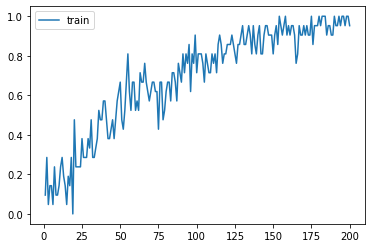

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [13]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [14]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [15]:
while True:
    # pedir input al usuario
    message = input("")
    # 
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else: # si no hubo ningún resultado que supere el umbral
        print("Perdón, no comprendo la pregunta.")
    

hola
1/1 [==============================] - 0s 175ms/step
BOT: Hola! ¿Cómo estás? Preguntame lo que sea sobre el Covid-19 ;)
sintomas
1/1 [==============================] - 0s 27ms/step
BOT: Si tenés dos o más de los siguientes síntomas: fiebre de 37,5°C, tos, dolor de garganta, dificultad respiratoria, dolor muscular, cefalea, diarrea y/o vómitos, o si tenés solo pérdida brusca de gusto u olfato, consultá al sistema de salud de tu localidad.
que es?
1/1 [==============================] - 0s 21ms/step
BOT: Los coronavirus son una familia de virus que pueden causar enfermedades en animales y en humanos. En los seres humanos pueden provocar infecciones respiratorias que van desde un resfrío común hasta enfermedades más graves, como el síndrome respiratorio de Medio Oriente (MERS) y el síndrome respiratorio agudo severo (SRAS-SARS).
Actualmente nos encontramos ante una pandemia (epidemia que se propaga a escala mundial) por un nuevo coronavirus, SARS-CoV-2, que fue descubierto recientemen

KeyboardInterrupt: Interrupted by user

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words